# Great Energy Predictor - Modeling (Electricity)
#### Hosted by: ASHRAE
##### Source: https://www.kaggle.com/c/ashrae-energy-prediction

### Dependencies

In [1]:
%matplotlib inline

import src.utils as udf

import gc
import joblib
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor

import lightgbm as lgb
import xgboost as xgb
import optuna

# import os

# Pandas on dask
# os.environ['MODIN_ENGINE'] = 'dask'
# import modin.pandas as dd 

# Pandas on ray
# os.environ['MODIN_ENGINE'] = 'ray'
# import ray
# ray.init()
# import modin.pandas as ray

In [2]:
# Plot settings
sns.set(rc={'figure.figsize': (16, 4),
            'font.size': 16})

### Load data

In [3]:
path = '../data/from_fts/'

In [4]:
train = pd.read_pickle(f'{path}train.pkl')
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18264895 entries, 0 to 18264894
Data columns (total 25 columns):
site_id               uint8
building_id           uint16
meter                 uint8
meter_type            category
timestamp             datetime64[ns]
meter_reading         float32
air_temperature       float32
dew_temperature       float32
sea_level_pressure    float32
wind_speed            float32
primary_use           category
square_feet           uint32
year_built            uint16
missing_year          uint8
dayofyear             uint16
month                 uint8
day                   uint8
hour                  uint8
dayofweek             uint8
wind_direction_x      float64
wind_direction_y      float64
rel_humidity          float32
is_weekend            int64
country               object
is_holiday            int64
dtypes: category(2), datetime64[ns](1), float32(6), float64(2), int64(2), object(1), uint16(3), uint32(1), uint8(7)
memory usage: 1.7+ GB


In [5]:
train = udf.reduce_mem_usage(train)
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18264895 entries, 0 to 18264894
Data columns (total 25 columns):
site_id               uint8
building_id           uint16
meter                 uint8
meter_type            category
timestamp             datetime64[ns]
meter_reading         float32
air_temperature       float32
dew_temperature       float32
sea_level_pressure    float32
wind_speed            float32
primary_use           category
square_feet           uint32
year_built            uint16
missing_year          uint8
dayofyear             uint16
month                 uint8
day                   uint8
hour                  uint8
dayofweek             uint8
wind_direction_x      float32
wind_direction_y      float32
rel_humidity          float32
is_weekend            uint8
country               object
is_holiday            uint8
dtypes: category(2), datetime64[ns](1), float32(8), object(1), uint16(3), uint32(1), uint8(9)
memory usage: 1.3+ GB


In [6]:
feats = pd.read_csv(f'{path}feats.csv')
feats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15 entries, 0 to 14
Data columns (total 7 columns):
correlation                  3 non-null object
lasso                        15 non-null object
lasso_alpha10                4 non-null object
lasso_recursive              10 non-null object
tree_importance              4 non-null object
tree_importance_recursive    10 non-null object
gradient_boosting            5 non-null object
dtypes: object(7)
memory usage: 968.0+ bytes


In [7]:
del path
gc.collect()

22

### Preprocessing

In [8]:
# Cast categorical feats as object type
train.primary_use = train.primary_use.astype('O')
train.country = train.country.astype('O')

# Drop features
train.drop(['site_id', 'air_temperature', 'meter_type', 'timestamp', 'month', 'day', 'dayofweek'], axis=1, inplace=True)
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18264895 entries, 0 to 18264894
Data columns (total 18 columns):
building_id           uint16
meter                 uint8
meter_reading         float32
dew_temperature       float32
sea_level_pressure    float32
wind_speed            float32
primary_use           object
square_feet           uint32
year_built            uint16
missing_year          uint8
dayofyear             uint16
hour                  uint8
wind_direction_x      float32
wind_direction_y      float32
rel_humidity          float32
is_weekend            uint8
country               object
is_holiday            uint8
dtypes: float32(7), object(2), uint16(3), uint32(1), uint8(5)
memory usage: 1.1+ GB


In [9]:
gc.collect()

44

### Split Data

In [10]:
# Groups of meter types in each country
train.groupby(['meter', 'country']).meter_reading.count().reset_index()

,meter,country,meter_reading
0,0,CA,135104
1,0,IE,314489
2,0,UK,1221731
3,0,US,9858944
4,1,CA,103230
5,1,US,3415640
6,2,CA,73432
7,2,US,2222617
8,3,CA,59086
9,3,UK,66183


In [11]:
# Groups of meters
train.groupby('meter').meter_reading.count()

meter
0    11530268
1     3518870
2     2296049
3      919708
Name: meter_reading, dtype: int64

In [12]:
# Split train set by meter type
train_df = []
for m in range(4):
    df = train[train.meter == m].drop('meter', axis=1)
    train_df.append(df)
    df.to_pickle(f'../data/from_mod/train_meter{m}.pkl')
    print(df.shape)

(11530268, 17)
(3518870, 17)
(2296049, 17)
(919708, 17)


In [13]:
# Save train set
path = '../data/from_mod/train.pkl'
train.to_pickle(path)
train = pd.read_pickle(path)
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18264895 entries, 0 to 18264894
Data columns (total 18 columns):
building_id           uint16
meter                 uint8
meter_reading         float32
dew_temperature       float32
sea_level_pressure    float32
wind_speed            float32
primary_use           object
square_feet           uint32
year_built            uint16
missing_year          uint8
dayofyear             uint16
hour                  uint8
wind_direction_x      float32
wind_direction_y      float32
rel_humidity          float32
is_weekend            uint8
country               object
is_holiday            uint8
dtypes: float32(7), object(2), uint16(3), uint32(1), uint8(5)
memory usage: 1.1+ GB


In [14]:
del m, df, path, train
gc.collect()

22

### Train/test split

In [15]:
# Split data and target
Xe = train_df[0].drop('meter_reading', axis=1).copy()
ye = train_df[0][['meter_reading']].copy()
print(Xe.shape)
print(ye.shape)

(11530268, 16)
(11530268, 1)


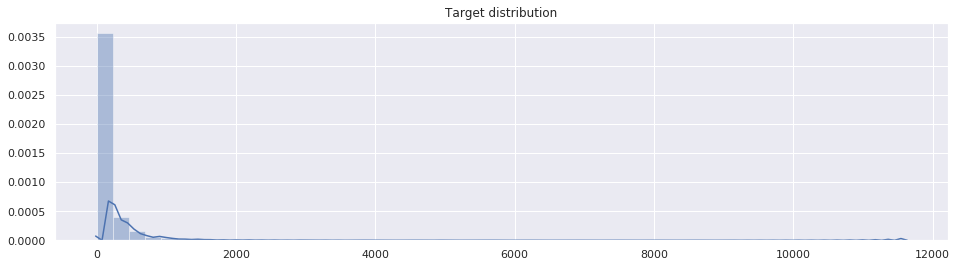

In [16]:
sns.distplot(ye)
plt.title('Target distribution');

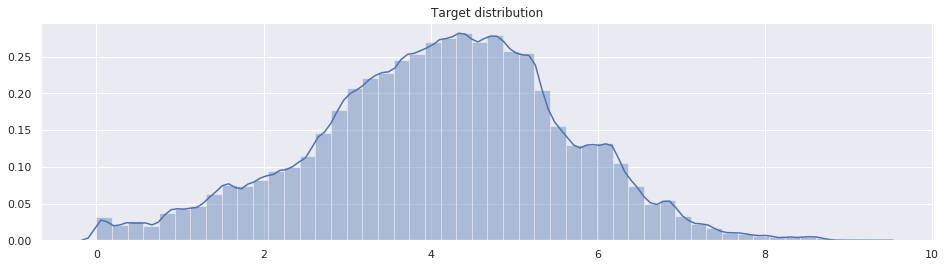

In [17]:
# Log transform target variable
ye = np.log1p(ye)
sns.distplot(ye)
plt.title('Target distribution');

In [18]:
# Train/val/test split
Xe_train, Xe_test, ye_train, ye_test = train_test_split(Xe, ye, test_size=0.20, random_state=42)
Xe_train, Xe_val, ye_train, ye_val = train_test_split(Xe_train, ye_train, test_size=0.25, random_state=42)

print('Train set:', Xe_train.shape, ye_train.shape)
print('Validation set:', Xe_val.shape, ye_val.shape)
print('Test set:', Xe_test.shape, ye_test.shape)

Train set: (6918160, 16) (6918160, 1)
Validation set: (2306054, 16) (2306054, 1)
Test set: (2306054, 16) (2306054, 1)


In [19]:
del Xe, ye
gc.collect()

11722

### Feature transformation

In [20]:
# Group all rare primary_use categories
Xe_train, Xe_val, Xe_test, rare_dict = udf.rare_encoder(Xe_train, Xe_test, ['primary_use'], val=Xe_val)
rare_dict

/home/tri/miniconda3/envs/minimal_ds/lib/python3.8/site-packages/sklearn/utils/validation.py:931: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  warnings.warn("Passing attributes to check_is_fitted is deprecated"


{'primary_use': Index(['Education', 'Office', 'Entertainment/public assembly',
        'Public services', 'Lodging/residential'],
       dtype='object')}

In [21]:
# Primary use counts
print('#####Train set#####')
print(Xe_train.primary_use.value_counts())
print('\n#####Validation set#####')
print(Xe_val.primary_use.value_counts())
print('\n#####Test set#####')
print(Xe_test.primary_use.value_counts())

#####Train set#####
Education                        2650245
Office                           1315718
Entertainment/public assembly     873373
Public services                   788047
Lodging/residential               679487
Rare                              611290
Name: primary_use, dtype: int64

#####Validation set#####
Education                        882732
Office                           438465
Entertainment/public assembly    291164
Public services                  262880
Lodging/residential              226485
Rare                             204328
Name: primary_use, dtype: int64

#####Test set#####
Education                        883410
Office                           438151
Entertainment/public assembly    292175
Public services                  262791
Lodging/residential              225749
Rare                             203778
Name: primary_use, dtype: int64


In [22]:
# Encode categorical features using the target mean of each category
Xe_train, Xe_val, Xe_test, mean_dict = udf.mean_encoder(Xe_train, ye_train, Xe_test, ['primary_use', 'country'], X_val=Xe_val)
mean_dict

{'primary_use': {'Education': 4.466021537780762,
  'Entertainment/public assembly': 3.5258514881134033,
  'Lodging/residential': 3.9752519130706787,
  'Office': 4.189361095428467,
  'Public services': 3.7608702182769775,
  'Rare': 3.743518352508545},
 'country': {'CA': 6.632948398590088,
  'IE': 3.9907801151275635,
  'UK': 3.273620128631592,
  'US': 4.174033164978027}}

In [23]:
# Encoded value counts in train set
print('#####primary_use#####')
print(Xe_train.primary_use.value_counts())
print('\n#####country#####')
print(Xe_train.country.value_counts())

#####primary_use#####
4.466022    2650245
4.189361    1315718
3.525851     873373
3.760870     788047
3.975252     679487
3.743518     611290
Name: primary_use, dtype: int64

#####country#####
4.174033    5915109
3.273620     733518
3.990780     188564
6.632948      80969
Name: country, dtype: int64


In [24]:
# Encoded value counts in validation set
print('#####primary_use#####')
print(Xe_val.primary_use.value_counts())
print('\n#####country#####')
print(Xe_val.country.value_counts())

#####primary_use#####
4.466022    882732
4.189361    438465
3.525851    291164
3.760870    262880
3.975252    226485
3.743518    204328
Name: primary_use, dtype: int64

#####country#####
4.174033    1972726
3.273620     243777
3.990780      62621
6.632948      26930
Name: country, dtype: int64


In [25]:
# Encoded value counts in test set
print('#####primary_use#####')
print(Xe_test.primary_use.value_counts())
print('\n#####country#####')
print(Xe_test.country.value_counts())

#####primary_use#####
4.466022    883410
4.189361    438151
3.525851    292175
3.760870    262791
3.975252    225749
3.743518    203778
Name: primary_use, dtype: int64

#####country#####
4.174033    1971109
3.273620     244436
3.990780      63304
6.632948      27205
Name: country, dtype: int64


In [26]:
# Scale features using their mean and standard deviation
Xe_train_scaled, Xe_val_scaled, Xe_test_scaled = udf.scale_feats(Xe_train, Xe_test, val=Xe_val)
Xe_train_scaled.head()

,building_id,dew_temperature,sea_level_pressure,wind_speed,primary_use,square_feet,year_built,missing_year,dayofyear,hour,wind_direction_x,wind_direction_y,rel_humidity,is_weekend,country,is_holiday
0,0.724584,-0.714907,1.525511,-0.886737,-1.034520,-0.738303,0.259551,0.906586,1.198764,-0.361373,-1.419794,0.093988,-0.336542,-0.63395,0.183565,-0.180253
1,0.788647,-0.623863,-1.646511,1.051496,0.250861,-0.564617,0.166172,0.906586,-1.248950,0.649812,-1.072330,1.069739,0.155318,-0.63395,-0.285694,-0.180253
2,1.717561,0.974460,-0.525605,-0.412947,-0.366424,-0.465626,0.399619,-1.103039,0.979708,0.505357,-1.397231,0.357586,0.712503,-0.63395,0.183565,-0.180253
3,0.675305,1.197012,-0.769143,-0.886737,1.048483,-0.135093,-0.113965,0.906586,-0.334629,0.360902,1.020026,1.256842,-0.379684,-0.63395,0.183565,-0.180253
4,-0.320136,0.185415,0.459177,1.137640,1.048483,0.249562,2.127132,-1.103039,1.322578,1.660997,-0.889273,1.256842,0.784773,-0.63395,0.183565,-0.180253


In [27]:
del Xe_train, Xe_val, Xe_test
gc.collect()

22

### Feature selection

In [28]:
feats.fillna('')

,correlation,lasso,lasso_alpha10,lasso_recursive,tree_importance,tree_importance_recursive,gradient_boosting
0,primary_use,building_id,primary_use,dew_temperature,building_id,building_id,building_id
1,square_feet,dew_temperature,square_feet,wind_speed,square_feet,air_temperature,primary_use
2,country,sea_level_pressure,is_weekend,primary_use,year_built,dew_temperature,square_feet
3,,wind_speed,country,square_feet,country,primary_use,year_built
4,,primary_use,,year_built,,square_feet,country
5,,square_feet,,hour,,year_built,
6,,year_built,,wind_direction_y,,dayofyear,
7,,missing_year,,is_weekend,,hour,
8,,dayofyear,,country,,dayofweek,
9,,hour,,is_holiday,,country,


In [29]:
# Lasso regularization feature set
lasso_feats = feats.lasso.tolist()
lasso_feats.remove('dayofweek')

print(len(lasso_feats))
lasso_feats

14


['building_id',
 'dew_temperature',
 'sea_level_pressure',
 'wind_speed',
 'primary_use',
 'square_feet',
 'year_built',
 'missing_year',
 'dayofyear',
 'hour',
 'wind_direction_y',
 'is_weekend',
 'country',
 'is_holiday']

In [30]:
# Recursive tree importance feature set
tree_feats = feats.tree_importance_recursive.tolist()[:10]
tree_feats.remove('air_temperature')
tree_feats.remove('dayofweek')

print(len(tree_feats))
tree_feats

8


['building_id',
 'dew_temperature',
 'primary_use',
 'square_feet',
 'year_built',
 'dayofyear',
 'hour',
 'country']

In [31]:
# Custom feature set 1
feats1 = Xe_train_scaled.columns.tolist()
feats1.remove('sea_level_pressure')
feats1.remove('wind_direction_x')
feats1.remove('wind_direction_y')
feats1.remove('rel_humidity')

print(len(feats1))
feats1

12


['building_id',
 'dew_temperature',
 'wind_speed',
 'primary_use',
 'square_feet',
 'year_built',
 'missing_year',
 'dayofyear',
 'hour',
 'is_weekend',
 'country',
 'is_holiday']

In [32]:
# Custom feature set 2
feats2 = feats1
feats2.remove('year_built')
feats2.remove('missing_year')

print(len(feats2))
feats2

10


['building_id',
 'dew_temperature',
 'wind_speed',
 'primary_use',
 'square_feet',
 'dayofyear',
 'hour',
 'is_weekend',
 'country',
 'is_holiday']

In [33]:
# PCA with 90% explained variance
pca90 = PCA(0.90)
pca90.fit(Xe_train_scaled)
Xe_train_pca = pd.DataFrame(pca90.transform(Xe_train_scaled))
Xe_val_pca = pd.DataFrame(pca90.transform(Xe_val_scaled))
Xe_test_pca = pd.DataFrame(pca90.transform(Xe_test_scaled))
Xe_train_pca.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,-0.646208,1.622990,-0.659110,-0.322557,-1.376255,0.226064,-0.578453,0.230422,-0.093745,0.833504,-1.910239,0.150667,0.600949
1,0.952057,0.258759,2.042788,0.133465,-0.479748,-0.119215,-0.321301,1.495559,-0.008457,-1.195596,0.183703,-0.722004,0.754971
2,-1.476182,0.235103,1.138884,0.500377,-0.093727,0.972673,-0.431577,0.054873,-0.124622,-0.346312,-0.878412,0.031973,0.079190
3,-0.594048,0.875288,0.345837,0.420509,0.248754,0.098320,-0.556381,0.493669,-1.118839,-0.698805,1.426786,-1.254000,-0.462669
4,-0.827649,-0.950359,-0.543681,1.772145,0.001169,1.342482,-0.392317,-0.395585,0.117912,-1.942272,-0.932271,-1.002777,1.257778


In [34]:
del feats
gc.collect()

22

### Lasso regression

In [35]:
# Lasso regression
params = {'alpha': [10 ** e for e in range(-6, 2)]}
lasso_og = GridSearchCV(Lasso(random_state=42), params, cv=8, scoring='neg_mean_squared_log_error', n_jobs=8, verbose=-1)
lasso_og.fit(Xe_train_scaled, ye_train)
pd.DataFrame(lasso_og.cv_results_).T

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  64 out of  64 | elapsed:  2.3min finished


,0,1,2,3,4,5,6,7
mean_fit_time,30.6677,26.4654,22.9499,18.276,12.4716,8.90372,5.73058,5.44368
std_fit_time,0.322479,0.763243,0.397995,1.00798,0.56447,0.389533,0.410054,0.232094
mean_score_time,0.199878,0.198873,0.209887,0.191324,0.205013,0.173513,0.110997,0.0840433
std_score_time,0.0541067,0.0672824,0.0674971,0.0616343,0.0632468,0.0648923,0.0265083,0.0262437
param_alpha,1e-06,1e-05,0.0001,0.001,0.01,0.1,1,10
params,{'alpha': 1e-06},{'alpha': 1e-05},{'alpha': 0.0001},{'alpha': 0.001},{'alpha': 0.01},{'alpha': 0.1},{'alpha': 1},{'alpha': 10}
split0_test_score,-0.0796523,-0.0796525,-0.0796553,-0.0796837,-0.0799971,-0.0843606,-0.123944,-0.123944
split1_test_score,-0.0797049,-0.0797052,-0.0797079,-0.0797358,-0.0800443,-0.0844322,-0.123993,-0.123993
split2_test_score,-0.0799093,-0.0799096,-0.0799125,-0.0799414,-0.0802634,-0.0847027,-0.124576,-0.124576
split3_test_score,-0.0801069,-0.0801072,-0.08011,-0.0801386,-0.0804564,-0.0848528,-0.124612,-0.124612


In [36]:
# Lasso regression with lasso_feats
params = {'alpha': [10 ** e for e in range(-6, 2)]}
lasso_lf = GridSearchCV(Lasso(random_state=42), params, cv=8, scoring='neg_mean_squared_log_error', n_jobs=8, verbose=-1)
lasso_lf.fit(Xe_train_scaled[lasso_feats], ye_train)
pd.DataFrame(lasso_lf.cv_results_).T

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  64 out of  64 | elapsed:  2.0min finished


,0,1,2,3,4,5,6,7
mean_fit_time,22.3294,21.5165,18.2244,16.2513,13.8357,8.57273,5.54961,4.98037
std_fit_time,0.481905,0.531248,0.522572,0.870019,0.90864,0.405137,0.604902,0.177854
mean_score_time,0.179128,0.186761,0.193697,0.187902,0.186738,0.15221,0.129753,0.0911866
std_score_time,0.0543634,0.0652928,0.067593,0.0723568,0.0557669,0.0444081,0.0251257,0.0273967
param_alpha,1e-06,1e-05,0.0001,0.001,0.01,0.1,1,10
params,{'alpha': 1e-06},{'alpha': 1e-05},{'alpha': 0.0001},{'alpha': 0.001},{'alpha': 0.01},{'alpha': 0.1},{'alpha': 1},{'alpha': 10}
split0_test_score,-0.0799858,-0.0799861,-0.0799888,-0.0800163,-0.0803295,-0.0843787,-0.123944,-0.123944
split1_test_score,-0.0800534,-0.0800537,-0.0800563,-0.0800834,-0.0803895,-0.0844502,-0.123993,-0.123993
split2_test_score,-0.0802552,-0.0802554,-0.0802582,-0.0802861,-0.0806026,-0.0847209,-0.124576,-0.124576
split3_test_score,-0.080454,-0.0804543,-0.080457,-0.0804843,-0.0807949,-0.0848713,-0.124612,-0.124612


In [37]:
# Lasso regression with tree_feats
params = {'alpha': [10 ** e for e in range(-6, 2)]}
lasso_tf = GridSearchCV(Lasso(random_state=42), params, cv=8, scoring='neg_mean_squared_log_error', n_jobs=8, verbose=-1)
lasso_tf.fit(Xe_train_scaled[tree_feats], ye_train)
pd.DataFrame(lasso_tf.cv_results_).T

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  64 out of  64 | elapsed:   58.8s finished


,0,1,2,3,4,5,6,7
mean_fit_time,10.1151,9.37847,8.22717,7.20558,6.78897,5.68553,3.68162,3.34731
std_fit_time,0.362445,0.17653,0.393407,0.221595,0.362293,0.400328,0.377992,0.188775
mean_score_time,0.164492,0.147656,0.158448,0.153075,0.158655,0.129314,0.0920228,0.0666973
std_score_time,0.0543343,0.0488965,0.0493471,0.0522952,0.0561798,0.0360449,0.0181351,0.0141649
param_alpha,1e-06,1e-05,0.0001,0.001,0.01,0.1,1,10
params,{'alpha': 1e-06},{'alpha': 1e-05},{'alpha': 0.0001},{'alpha': 0.001},{'alpha': 0.01},{'alpha': 0.1},{'alpha': 1},{'alpha': 10}
split0_test_score,-0.0804028,-0.080403,-0.0804052,-0.0804271,-0.0806708,-0.0843787,-0.123944,-0.123944
split1_test_score,-0.0804463,-0.0804465,-0.0804487,-0.0804707,-0.0807168,-0.0844502,-0.123993,-0.123993
split2_test_score,-0.0806731,-0.0806733,-0.0806756,-0.0806979,-0.0809464,-0.0847209,-0.124576,-0.124576
split3_test_score,-0.0808611,-0.0808614,-0.0808635,-0.0808857,-0.0811326,-0.0848713,-0.124612,-0.124612


In [38]:
# Lasso regression with feats1
params = {'alpha': [10 ** e for e in range(-6, 2)]}
lasso_f1 = GridSearchCV(Lasso(random_state=42), params, cv=8, scoring='neg_mean_squared_log_error', n_jobs=8, verbose=-1)
lasso_f1.fit(Xe_train_scaled[feats1], ye_train)
pd.DataFrame(lasso_f1.cv_results_).T

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  64 out of  64 | elapsed:  1.2min finished


,0,1,2,3,4,5,6,7
mean_fit_time,12.476,11.1368,9.89808,9.92759,9.36073,6.26318,4.03824,4.06726
std_fit_time,0.229189,0.496181,0.192194,0.236279,0.24821,0.185963,0.307076,0.196113
mean_score_time,0.162383,0.163645,0.171138,0.17452,0.169542,0.165893,0.103161,0.0928969
std_score_time,0.0488045,0.0590231,0.0617692,0.058989,0.0573816,0.043288,0.0164581,0.0372947
param_alpha,1e-06,1e-05,0.0001,0.001,0.01,0.1,1,10
params,{'alpha': 1e-06},{'alpha': 1e-05},{'alpha': 0.0001},{'alpha': 0.001},{'alpha': 0.01},{'alpha': 0.1},{'alpha': 1},{'alpha': 10}
split0_test_score,-0.0812981,-0.0812984,-0.0813006,-0.0813237,-0.0815789,-0.0848748,-0.123944,-0.123944
split1_test_score,-0.081361,-0.0813612,-0.0813635,-0.0813868,-0.0816405,-0.0849459,-0.123993,-0.123993
split2_test_score,-0.0815552,-0.0815555,-0.0815578,-0.0815815,-0.0818424,-0.0852139,-0.124576,-0.124576
split3_test_score,-0.0817178,-0.081718,-0.0817203,-0.081744,-0.0820039,-0.0853579,-0.124612,-0.124612


In [39]:
# Lasso regression with feats2
params = {'alpha': [10 ** e for e in range(-6, 2)]}
lasso_f2 = GridSearchCV(Lasso(random_state=42), params, cv=8, scoring='neg_mean_squared_log_error', n_jobs=8, verbose=-1)
lasso_f2.fit(Xe_train_scaled[feats2], ye_train)
pd.DataFrame(lasso_f2.cv_results_).T

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  64 out of  64 | elapsed:  1.2min finished


,0,1,2,3,4,5,6,7
mean_fit_time,12.2415,11.1861,9.87905,9.84076,9.47018,6.36589,4.08167,4.06704
std_fit_time,0.496714,0.24201,0.390005,0.350404,0.0961286,0.375295,0.294857,0.107449
mean_score_time,0.162593,0.174927,0.162399,0.163404,0.153437,0.160009,0.113314,0.0957084
std_score_time,0.054298,0.0635276,0.0441117,0.0675558,0.0516199,0.0556592,0.0242839,0.034485
param_alpha,1e-06,1e-05,0.0001,0.001,0.01,0.1,1,10
params,{'alpha': 1e-06},{'alpha': 1e-05},{'alpha': 0.0001},{'alpha': 0.001},{'alpha': 0.01},{'alpha': 0.1},{'alpha': 1},{'alpha': 10}
split0_test_score,-0.0812981,-0.0812984,-0.0813006,-0.0813237,-0.0815789,-0.0848748,-0.123944,-0.123944
split1_test_score,-0.081361,-0.0813612,-0.0813635,-0.0813868,-0.0816405,-0.0849459,-0.123993,-0.123993
split2_test_score,-0.0815552,-0.0815555,-0.0815578,-0.0815815,-0.0818424,-0.0852139,-0.124576,-0.124576
split3_test_score,-0.0817178,-0.081718,-0.0817203,-0.081744,-0.0820039,-0.0853579,-0.124612,-0.124612


In [40]:
# Lasso regression with PCA
params = {'alpha': [10 ** e for e in range(-6, 2)]}
lasso_pca = GridSearchCV(Lasso(random_state=42), params, cv=8, scoring='neg_mean_squared_log_error', n_jobs=8, verbose=-1)
lasso_pca.fit(Xe_train_pca, ye_train)
pd.DataFrame(lasso_pca.cv_results_).T

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  64 out of  64 | elapsed:  1.3min finished


,0,1,2,3,4,5,6,7
mean_fit_time,9.51524,9.57383,9.52305,9.67701,9.39892,9.07241,6.92433,5.83435
std_fit_time,0.47781,0.669936,0.44701,0.443464,0.567749,0.616773,0.506003,0.225942
mean_score_time,0.210616,0.211073,0.203287,0.167497,0.183666,0.154663,0.138682,0.0848067
std_score_time,0.0810424,0.0767098,0.0518667,0.0536635,0.05744,0.0149113,0.00860825,0.0211727
param_alpha,1e-06,1e-05,0.0001,0.001,0.01,0.1,1,10
params,{'alpha': 1e-06},{'alpha': 1e-05},{'alpha': 0.0001},{'alpha': 0.001},{'alpha': 0.01},{'alpha': 0.1},{'alpha': 1},{'alpha': 10}
split0_test_score,-0.0814375,-0.0814378,-0.0814413,-0.0814767,-0.0818616,-0.0876473,-0.123944,-0.123944
split1_test_score,-0.0814839,-0.0814842,-0.0814878,-0.0815242,-0.0819194,-0.087784,-0.123993,-0.123993
split2_test_score,-0.0817021,-0.0817025,-0.081706,-0.0817419,-0.0821319,-0.0879658,-0.124576,-0.124576
split3_test_score,-0.0818735,-0.0818738,-0.0818773,-0.0819129,-0.0823005,-0.0881072,-0.124612,-0.124612


In [41]:
# Best cross validation
cross_val_score(Lasso(alpha=1e-6, random_state=42), Xe_train_scaled, ye_train, scoring='neg_mean_squared_log_error', cv=8, n_jobs=8)

array([-0.07965225, -0.07970493, -0.07990935, -0.08010694, -0.08012504,
       -0.08016985, -0.08024574, -0.07955575])

In [42]:
# Training on all features
lasso_ogft = Lasso(alpha=1e-6, random_state=42)
lasso_ogft.fit(Xe_train_scaled, ye_train)

# Validation scores
pred_val = lasso_ogft.predict(Xe_val_scaled)
msle_val = mean_squared_log_error(ye_val, pred_val)
rmsle_val = np.sqrt(msle_val)
print('All features')
print('MSLE:', msle_val)
print('RMSLE:', rmsle_val)

All features
MSLE: 0.07981947569161967
RMSLE: 0.28252340733401127


In [43]:
# Test scores
pred_test = lasso_ogft.predict(Xe_test_scaled)
msle_test = mean_squared_log_error(ye_test, pred_test)
rmsle_test = np.sqrt(msle_test)
print('All features')
print('MSLE:', msle_test)
print('RMSLE:', rmsle_test)

All features
MSLE: 0.07998044039539719
RMSLE: 0.2828081335382651


In [44]:
# Training on lasso_feats
lasso_l1ft = Lasso(alpha=1e-6, random_state=42)
lasso_l1ft.fit(Xe_train_scaled, ye_train)

# Validation scores
pred_val = lasso_l1ft.predict(Xe_val_scaled)
msle_val = mean_squared_log_error(ye_val, pred_val)
rmsle_val = np.sqrt(msle_val)
print('Lasso feature set')
print('MSLE:', msle_val)
print('RMSLE:', rmsle_val)

Lasso feature set
MSLE: 0.07981947569161967
RMSLE: 0.28252340733401127


In [45]:
# Test scores
pred_test = lasso_l1ft.predict(Xe_test_scaled)
msle_test = mean_squared_log_error(ye_test, pred_test)
rmsle_test = np.sqrt(msle_test)
print('Lasso feature set')
print('MSLE:', msle_test)
print('RMSLE:', rmsle_test)

Lasso feature set
MSLE: 0.07998044039539719
RMSLE: 0.2828081335382651


In [46]:
# Training on tree_feats
lasso_dtft = Lasso(alpha=1e-6, random_state=42)
lasso_dtft.fit(Xe_train_scaled, ye_train)

# Validation scores
pred_val = lasso_dtft.predict(Xe_val_scaled)
msle_val = mean_squared_log_error(ye_val, pred_val)
rmsle_val = np.sqrt(msle_val)
print('Tree feature set')
print('MSLE:', msle_val)
print('RMSLE:', rmsle_val)

Tree feature set
MSLE: 0.07981947569161967
RMSLE: 0.28252340733401127


In [47]:
# Test scores
pred_test = lasso_dtft.predict(Xe_test_scaled)
msle_test = mean_squared_log_error(ye_test, pred_test)
rmsle_test = np.sqrt(msle_test)
print('Tree feature set')
print('MSLE:', msle_test)
print('RMSLE:', rmsle_test)

Tree feature set
MSLE: 0.07998044039539719
RMSLE: 0.2828081335382651


In [48]:
del params, lasso_f1, lasso_f2, lasso_pca, pred_val, msle_val, rmsle_val, pred_test, msle_test, rmsle_test
gc.collect()

1756

### LightGBM

In [49]:
# Objective function for parameter optimization
def objective_lgb(trial):
    
    joblib.dump(study_lgb, '../objects/study_lgb.pkl')
    
    dtrain = lgb.Dataset(Xe_train_scaled, label=ye_train)
    dval = lgb.Dataset(Xe_val_scaled, label=ye_val)

    params = {
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-4, 1e1),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-4, 1e1),
        'max_depth': trial.suggest_int('max_depth', 2, 100),
        'num_leaves': trial.suggest_int('num_leaves', 2, 2048),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 5, 5000),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.5, 1.0),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
        'num_iterations': 5000,
        'early_stopping_round': 10,
        'metric': 'rmse',
        'num_threads': -1,
        'seed': 42
    }
    
    lgbm = lgb.train(params, dtrain, valid_sets=[dtrain, dval], valid_names=['train', 'valid'], verbose_eval=False)
    pred = lgbm.predict(Xe_val_scaled)
    pred[pred < 0] = 0
    loss = mean_squared_log_error(ye_val, pred)

#     cv = lgb.cv(params, dtrain, folds=KFold(10, shuffle=True, random_state=42), verbose_eval=False)
#     loss = cv['rmse-mean'][-1]
    
    return loss

In [50]:
# print(datetime.datetime.now())

# # Enable logging
# optuna.logging.enable_default_handler()

# # Optimize parameters
# study_lgb = optuna.create_study(direction='minimize')
# study_lgb.optimize(objective_lgb, n_trials=50)

# print(datetime.datetime.now())

# print(f'Finished trials: {len(study_lgb.trials)}')
# print(f'Best trial: {study_lgb.best_trial.value}')
# best_trial_lgb.params

In [28]:
# Study results
study_lgb = joblib.load('../objects/electricity/study_lgb.pkl')
print(f'Finished trials: {len(study_lgb.trials)}')
print(f'Best trial: {study_lgb.best_trial.value}')
study_lgb.best_trial.params

Finished trials: 100
Best trial: 0.0018293180635630408


{'learning_rate': 0.07916336777546343,
 'lambda_l1': 0.008557356431137609,
 'lambda_l2': 0.0006037228650908533,
 'max_depth': 51,
 'num_leaves': 923,
 'min_child_samples': 7,
 'subsample': 0.7399597912518232,
 'feature_fraction': 0.7310599981838332}

In [ ]:
# LightGBM datasets for validation
edtrain = lgb.Dataset(Xe_train_scaled, label=ye_train)
edval = lgb.Dataset(Xe_val_scaled, label=ye_val)

# Parameters from Optuna
params_lgb = dict(study_lgb.best_trial.params)
params_lgb['num_iterations'] = 10000
params_lgb['early_stopping_round'] = 10
params_lgb['metric'] = 'rmse'
params_lgb['num_threads'] = -1
params_lgb['seed'] = 42

# Train data
lgbm = lgb.train(params_lgb, edtrain, valid_sets=[edtrain, edval], verbose_eval=False)
lgbm.save_model('../objects/electricity/lgbm.txt')

/home/tri/miniconda3/envs/minimal_ds/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/tri/miniconda3/envs/minimal_ds/lib/python3.8/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


In [59]:
# Train set RMSLE
pred_train = lgbm.predict(Xe_train_scaled)
pred_train[pred_train < 0] = 0
rmsle_train = np.sqrt(mean_squared_log_error(ye_train, pred_train))
print('Train RMSLE:', rmsle_train)

# Validation set RMSLE
pred_val = lgbm.predict(Xe_val_scaled)
pred_val[pred_val < 0] = 0
rmsle_val = np.sqrt(mean_squared_log_error(ye_val, pred_val))
print('Validation RMSLE:', rmsle_val)

# Test set RMSLE
pred_test = lgbm.predict(Xe_test_scaled)
pred_test[pred_test < 0] = 0
rmsle_test = np.sqrt(mean_squared_log_error(ye_test, pred_test))
print('Test RMSLE:', rmsle_test)

Train RMSLE: 0.026196208827996406
Validation RMSLE: 0.04244904812929961
Test RMSLE: 0.04243108424829185


In [60]:
del edtrain, edval, pred_train, rmsle_train, pred_val, rmsle_val, pred_test, rmsle_test
gc.collect()

113

### XGBoost

In [80]:
# Objective function for parameter optimization
def objective_xgb(trial):
    
    joblib.dump(study_xgb, '../objects/study_xgb.pkl')
    
    dtrain = xgb.DMatrix(Xe_val_scaled, label=ye_val)
    dval = xgb.DMatrix(Xe_test_scaled, label=ye_test)

    params = {
        'grow_policy': trial.suggest_categorical('grow_policy', ['depthwise', 'lossguide']),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
        'alpha': trial.suggest_loguniform('alpha', 1e-4, 1e1),
        'lambda': trial.suggest_loguniform('lambda', 1e-4, 1e1),
        'gamma': trial.suggest_loguniform('gamma', 1e-4, 1e1),
        'max_depth': trial.suggest_int('max_depth', 2, 100),
        'max_leaves': trial.suggest_int('max_leaves', 2, 2024),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
        'eval_metric': 'rmse',
        'seed': 42
    }
    
    xg = xgb.train(params, dtrain, 
                   evals=[(dtrain, 'train'), (dval, 'valid')],
                   num_boost_round=1000, 
                   early_stopping_rounds=10,
                   verbose_eval=False)
    pred = xg.predict(dval)
    pred[pred < 0] = 0
    loss = mean_squared_log_error(ye_test, pred)

#     cv = xgb.cv(params, dtrain, folds=KFold(10, shuffle=True, random_state=42), verbose_eval=False)
#     loss = cv['rmse-mean'][-1]
    
    return loss

In [81]:
# print(f'Start: {datetime.datetime.now()}')

# # Optimize parameters
# study_xgb = optuna.create_study(direction='minimize')
# study_xgb.optimize(objective_xgb, n_trials=50)

# print(f'End: {datetime.datetime.now()}')

# print(f'Finished trials: {len(study_xgb.trials)}')
# print(f'Best trial: {study_xgb.best_trial.value}')
# study_xgb.best_trial.params

Start: 2020-02-23 13:13:18.932007


[I 2020-02-23 14:26:00,411] Finished trial#0 resulted in value: 1.014672040939331. Current best value is 1.014672040939331 with parameters: {'grow_policy': 'depthwise', 'learning_rate': 0.00010069183554683488, 'alpha': 0.14384678195306266, 'lambda': 0.1317389907961515, 'gamma': 0.008574945454197852, 'max_depth': 51, 'max_leaves': 492, 'subsample': 0.7480647963609484, 'colsample_bytree': 0.6682914717308165}.
[I 2020-02-23 15:51:13,613] Finished trial#1 resulted in value: 0.003139552427455783. Current best value is 0.003139552427455783 with parameters: {'grow_policy': 'lossguide', 'learning_rate': 0.010676140508226309, 'alpha': 7.6730547426007245, 'lambda': 0.26342508503760165, 'gamma': 0.16128207492657728, 'max_depth': 77, 'max_leaves': 1442, 'subsample': 0.9948830575483186, 'colsample_bytree': 0.7813337482336993}.
[I 2020-02-23 16:43:50,431] Finished trial#2 resulted in value: 1.0121127367019653. Current best value is 0.003139552427455783 with parameters: {'grow_policy': 'lossguide', '

End: 2020-02-26 15:52:59.271846
Finished trials: 50
Best trial: 0.0020912776235491037


NameError: name 'best_trial_xgb' is not defined

In [ ]:
# Study results
study_xgb = joblib.load('../objects/electricity/study_xgb.pkl')
print(f'Finished trials: {len(study_xgb.trials)}')
print(f'Best trial: {study_xgb.best_trial.value}')
study_xgb.best_trial.params

In [ ]:
# XGBoost datasets for validation
edtrain = xgb.DMatrix(Xe_train_scaled, label=ye_train)
edval = xgb.DMatrix(Xe_val_scaled, label=ye_val)
edtest = xgb.DMatrix(Xe_test_scaled, label=ye_test)

# Parameters from Optuna
params_xgb = dict(study_xgb.best_trial.params)
params_xgb['eval_metric'] = 'rmse'
params_xgb['seed'] = 42

# Train data
xg = xgb.train(params_xgb, edtrain, 
               evals=[(edtrain, 'train'), (edval, 'valid')], 
               num_boost_round=1000,
               early_stopping_rounds=10,
               verbose_eval=False)
xg.save_model('../objects/electricity/xg.txt')

In [ ]:
# Train set RMSLE
pred_train = xg.predict(edtrain)
pred_train[pred_train < 0] = 0
rmsle_train = np.sqrt(mean_squared_log_error(ye_train, pred_train))
print('Train RMSLE:', rmsle_train)

# Validation set RMSLE
pred_val = xg.predict(edval)
pred_val[pred_val < 0] = 0
rmsle_val = np.sqrt(mean_squared_log_error(ye_val, pred_val))
print('Validation RMSLE:', rmsle_val)

# Test set RMSLE
pred_test = xg.predict(edtest)
pred_test[pred_test < 0] = 0
rmsle_test = np.sqrt(mean_squared_log_error(ye_test, pred_test))
print('Test RMSLE:', rmsle_test)

In [100]:
del edtrain, edval, edtest, pred_train, rmsle_train, pred_val, rmsle_val, pred_test, rmsle_test
gc.collect()

166